In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Also import seaborn if you're using sns.histplot

import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('marketing_campaign.csv')  # replace with the actual filename
df.head()  # to preview the data


Saving marketing_campaign.csv to marketing_campaign.csv


Date Facebook Ad Campaign  Facebook Ad Views  Facebook Ad Clicks  \
0  1/1/2019             FB_Jan19               2116                  18   
1  1/2/2019             FB_Jan19               3106                  36   
2  1/3/2019             FB_Jan19               3105                  26   
3  1/4/2019             FB_Jan19               1107                  27   
4  1/5/2019             FB_Jan19               1317                  15   

   Facebook Ad Conversions Cost per Facebook Ad  \
0                        8                 $126   
1                       12                 $104   
2                        8                 $102   
3                        9                  $71   
4                        7                  $78   

  Facebook Click-Through Rate (Clicks / View)  \
0                                       0.83%   
1                                       1.15%   
2                                       0.84%   
3                                       2.45%   
4                                       1.10%   

  Facebook Conversion Rate (Conversions / Clicks)  \
0                                          42.73%   
1                                          34.04%   
2                                          31.45%   
3                                          34.76%   
4                                          47.59%   

  Facebook Cost per Click (Ad Cost / Clicks) AdWords Ad Campaign  \
0                                      $7.14            AW_Jan19   
1                                      $2.91            AW_Jan19   
2                                      $3.89            AW_Jan19   
3                                      $2.62            AW_Jan19   
4                                      $5.38            AW_Jan19   

   AdWords Ad Views  AdWords Ad Clicks  AdWords Ad Conversions  \
0              4984                 59                       5   
1              4022                 71                       6   
2              3863                 44                       4   
3              3911                 49                       5   
4              4070                 55                       7   

  Cost per AdWords Ad AdWords Click-Through Rate (Clicks / View)  \
0                $194                                      1.18%   
1                 $75                                      1.77%   
2                $141                                      1.13%   
3                $141                                      1.26%   
4                $133                                      1.36%   

  AdWords Conversion Rate (Conversions / Click)  \
0                                         8.40%   
1                                         7.80%   
2                                         9.59%   
3                                        11.08%   
4                                        12.22%   

  AdWords Cost per Click (Ad Cost / Clicks)  
0                                     $3.30  
1                                     $1.05  
2                                     $3.23  
3                                     $2.86  
4                                     $2.40

In [ ]:
df.shape

(365, 17)

In [ ]:
df.dtypes

Date                                               object
Facebook Ad Campaign                               object
Facebook Ad Views                                   int64
Facebook Ad Clicks                                  int64
Facebook Ad Conversions                             int64
Cost per Facebook Ad                               object
Facebook Click-Through Rate (Clicks / View)        object
Facebook Conversion Rate (Conversions / Clicks)    object
Facebook Cost per Click (Ad Cost / Clicks)         object
AdWords Ad Campaign                                object
AdWords Ad Views                                    int64
AdWords Ad Clicks                                   int64
AdWords Ad Conversions                              int64
Cost per AdWords Ad                                object
AdWords Click-Through Rate (Clicks / View)         object
AdWords Conversion Rate (Conversions / Click)      object
AdWords Cost per Click (Ad Cost / Clicks)          object
dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.describe()

Date  Facebook Ad Views  Facebook Ad Clicks  \
count                  365         365.000000          365.000000   
mean   2019-07-02 00:00:00        2179.687671           44.049315   
min    2019-01-01 00:00:00        1050.000000           15.000000   
25%    2019-04-02 00:00:00        1656.000000           35.000000   
50%    2019-07-02 00:00:00        2202.000000           43.000000   
75%    2019-10-01 00:00:00        2717.000000           54.000000   
max    2019-12-31 00:00:00        3320.000000           73.000000   
std                    NaN         618.074639           12.140559   

       Facebook Ad Conversions  AdWords Ad Views  AdWords Ad Clicks  \
count               365.000000         365.00000         365.000000   
mean                 11.742466        4717.19726          60.383562   
min                   5.000000        3714.00000          31.000000   
25%                  10.000000        4247.00000          49.000000   
50%                  12.000000        4711.00000          60.000000   
75%                  13.000000        5190.00000          73.000000   
max                  19.000000        5760.00000          89.000000   
std                   2.924786         561.11406          14.368225   

       AdWords Ad Conversions  
count              365.000000  
mean                 5.980822  
min                  3.000000  
25%                  5.000000  
50%                  6.000000  
75%                  7.000000  
max                  9.000000  
std                  1.628106

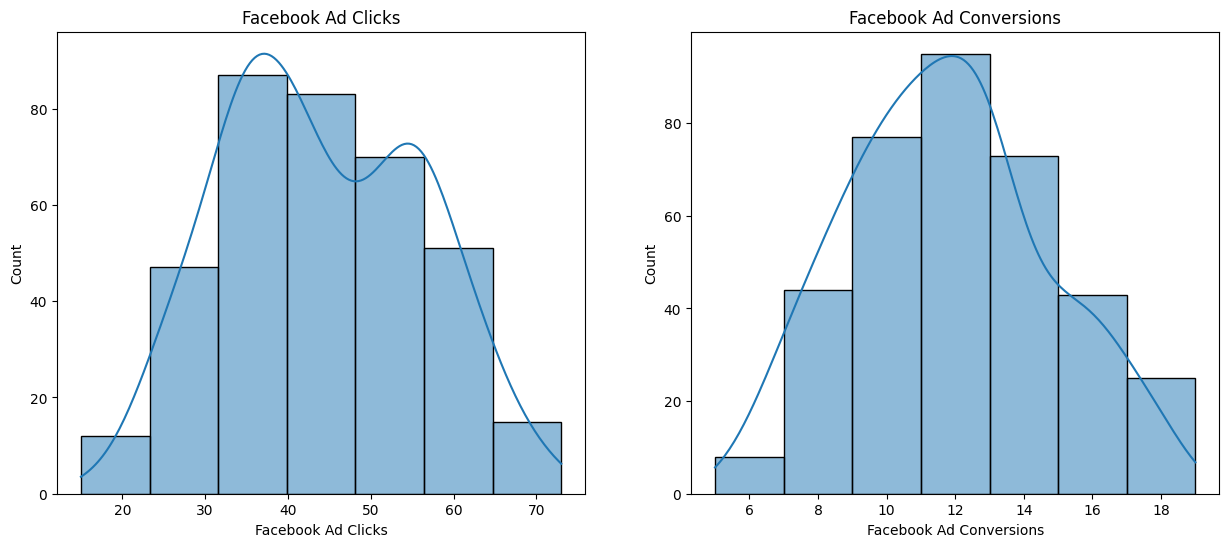

In [ ]:
#distribution of the clicks and conversions
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Facebook Ad Clicks')
sns.histplot(df['Facebook Ad Clicks'], bins = 7 , edgecolor = 'k' , kde = True)
plt.subplot(1,2,2)
plt.title('Facebook Ad Conversions')
sns.histplot(df['Facebook Ad Conversions'], bins = 7 , edgecolor = 'k' , kde = True)
plt.show()

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('AdWords Ad Clicks')
sns.histplot(df['AdWords Ad Clicks'], bins = 7 , edgecolor = 'k' , kde = True)
plt.subplot(1,2,2)
plt.title('AdWords Ad Conversions')
sns.histplot(df['AdWords Ad Conversions'] , bins = 7 , edgecolor = 'k' , kde = True)
plt.show()

In [ ]:
df['Facebook Ad Conversions']

0       8
1      12
2       8
3       9
4       7
       ..
360    13
361    18
362    13
363     8
364    17
Name: Facebook Ad Conversions, Length: 365, dtype: int64

In [ ]:
# Creating function to calculate the category for the conversions
def create_conversion_category(conversion_col):
    category = []
    for conversion in df[conversion_col]:
        if conversion < 6:
            category.append('less than 6')
        elif 6 <= conversion < 11:
            category.append('6-10')
        elif 11 <= conversion < 16:
            category.append('10-15')
        else:
            category.append('more than 15')
    return category  # <- return should be outside the loop

# Applying function to different campaign conversions
df['Facebook Conversion Category'] = create_conversion_category('Facebook Ad Conversions')
df['AdWords Conversion Category'] = create_conversion_category('AdWords Ad Conversions')


In [ ]:
df[['Facebook Ad Conversions', 'Facebook Conversions Category',
    'AdWords Ad Conversions', 'AdWords Conversions Category']].head()


Facebook Ad Conversions Facebook Conversions Category  \
0                        8                          6-10   
1                       12                         11-15   
2                        8                          6-10   
3                        9                          6-10   
4                        7                          6-10   

   AdWords Ad Conversions AdWords Conversions Category  
0                       5                  less than 6  
1                       6                         6-10  
2                       4                  less than 6  
3                       5                  less than 6  
4                       7                         6-10

In [ ]:
df[['Facebook Ad Conversions', 'Facebook Ad Conversions Category',
    'AdWords Ad Conversions', 'AdWords Ad Conversions Category']].head()


Facebook Ad Conversions Facebook Ad Conversions Category  \
0                        8                             6-10   
1                       12                            11-15   
2                        8                             6-10   
3                        9                             6-10   
4                        7                             6-10   

   AdWords Ad Conversions AdWords Ad Conversions Category  
0                       5                     less than 6  
1                       6                            6-10  
2                       4                     less than 6  
3                       5                     less than 6  
4                       7                            6-10

In [ ]:
df['Facebook Conversions Category'].value_counts()


Facebook Conversions Category
11-15           189
6-10            128
more than 15     47
less than 6       1
Name: count, dtype: int64

In [ ]:
pd.DataFrame(df['Facebook Conversions Category'].value_counts())


count
Facebook Conversions Category       
11-15                            189
6-10                             128
more than 15                      47
less than 6                        1

In [ ]:
facebook = pd.DataFrame(df['Facebook Conversions Category'].value_counts()).reset_index().rename(columns = {'Facebook Conversions Category': 'Category'})
facebook

Category  count
0         11-15    189
1          6-10    128
2  more than 15     47
3   less than 6      1

In [ ]:
df['AdWords Conversions Category'].value_counts()

AdWords Conversions Category
6-10           209
less than 6    156
Name: count, dtype: int64

In [ ]:
pd.DataFrame(df['AdWords Conversions Category'].value_counts())


count
AdWords Conversions Category       
6-10                            209
less than 6                     156

In [ ]:
adwords = pd.DataFrame(df['AdWords Conversions Category'].value_counts()).reset_index().rename(columns = {'AdWords Conversions Category': 'Category'})
adwords

Category  count
0         6-10    209
1  less than 6    156

In [ ]:
category_df = pd.merge(facebook, adwords, on='Category', how='outer').fillna(0)
category_df


Category  count_x  count_y
0         6-10      209      209
1  less than 6      156      156

In [ ]:
category_df = category_df.iloc[[3,1,0,2]]
category_df

IndexError: positional indexers are out-of-bounds